In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from math import floor, ceil
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
from os.path import exists as DoesPathExist
train_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv"
train_scores_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv"
test_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv"
sample_submission_path = "/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv"

if DoesPathExist(train_logs_path):
    train_logs: pd.DataFrame = pd.read_csv(train_logs_path)
else:
    train_logs: pd.DataFrame = pd.read_csv("./data/train_logs.csv")

if DoesPathExist(train_scores_path):
    train_scores = pd.read_csv(train_scores_path)
else:
    train_scores = pd.read_csv("./data/train_scores.csv")

if DoesPathExist(test_logs_path):
    test_logs = pd.read_csv(test_logs_path)
else:
    test_logs = pd.read_csv("./data/test_logs.csv")
    
if DoesPathExist(sample_submission_path):
    sample_submission = pd.read_csv(sample_submission_path)
else:
    sample_submission = pd.read_csv("./data/sample_submission.csv")
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('expand_frame_repr', False)

In [2]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [3]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [4]:
train_logs.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.999]).round(0)

,event_id,down_time,up_time,action_time,cursor_position,word_count
count,8405898.0,8405898.0,8405898.0,8405898.0,8405898.0,8405898.0
mean,2068.0,793560.0,793658.0,98.0,1223.0,231.0
std,1588.0,514945.0,514943.0,253.0,949.0,176.0
min,1.0,106.0,252.0,0.0,0.0,0.0
1%,35.0,47863.0,47964.0,0.0,9.0,2.0
5%,171.0,109978.0,110076.0,12.0,87.0,18.0
25%,852.0,373184.0,373282.0,66.0,499.0,96.0
50%,1726.0,720886.0,720980.0,93.0,1043.0,200.0
75%,2926.0,1163042.0,1163141.0,122.0,1706.0,327.0
95%,5121.0,1664020.0,1664111.0,176.0,3037.0,565.0


## Data Analysis

#### Score Distribution

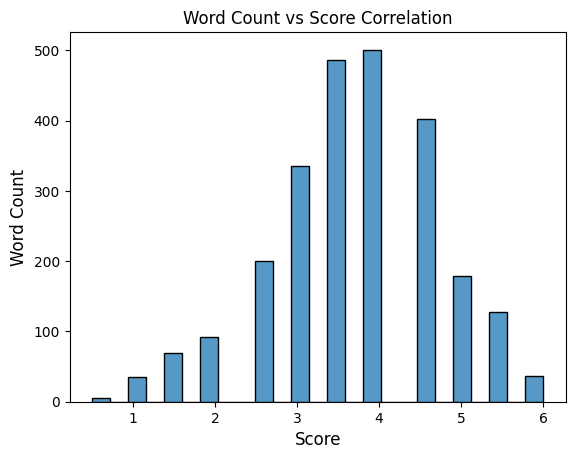

In [5]:
unique, counts = np.unique(train_scores.score, return_counts=True)
sns.histplot(data=train_scores["score"])
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.title("Word Count vs Score Correlation")
plt.show()

#### Word Count Analysis
Here we will be looking at the effect of the word count on the outcome.

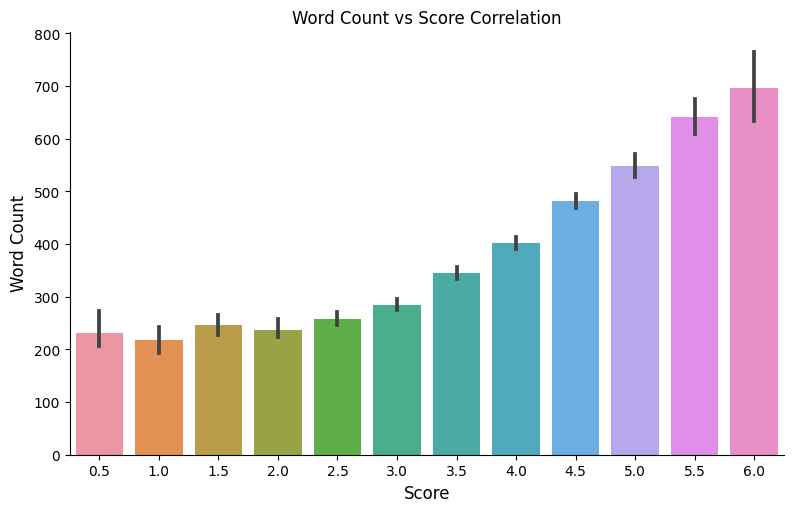

In [6]:
stats = train_logs.groupby("id")["word_count"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="word_count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.title("Word Count vs Score Correlation")
plt.show()

In [7]:
stats.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).round(1)

,word_count
count,2471.0
mean,390.0
std,172.5
min,35.0
1%,199.7
5%,204.0
25%,255.0
50%,351.0
75%,480.0
95%,724.0


#### Event Analysis

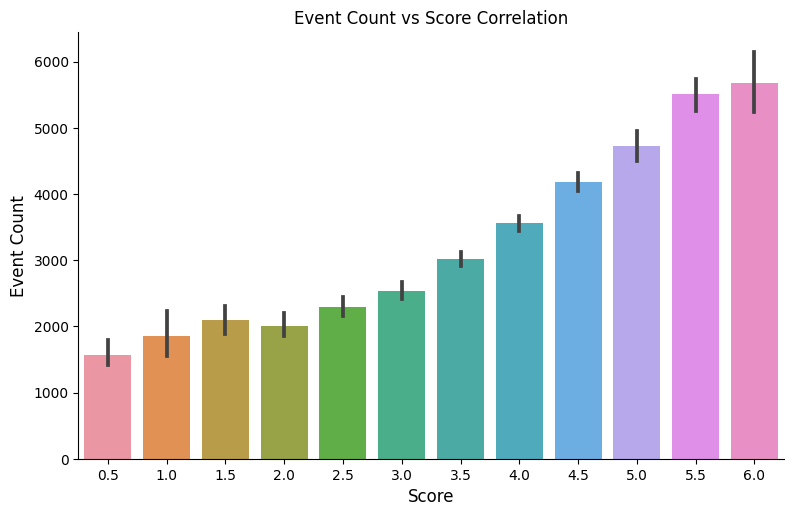

In [8]:
stats = train_logs.groupby("id")["event_id"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.title("Event Count vs Score Correlation")
plt.show()

In [9]:
stats.describe(percentiles=[0.02, 0.05, 0.25, 0.5, 0.75, 0.95, 0.98]).round(1)

,event_id
count,2471.0
mean,3401.8
std,1578.9
min,262.0
2%,1377.8
5%,1524.5
25%,2193.5
50%,3082.0
75%,4301.0
95%,6387.5


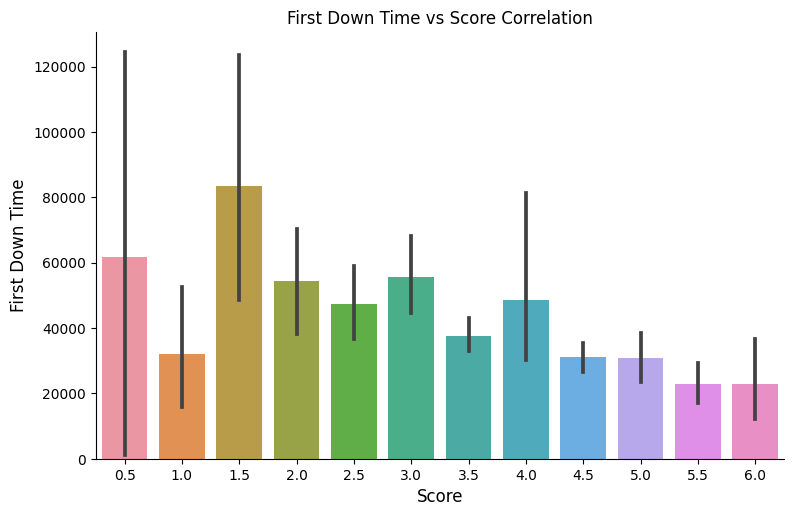

In [10]:
stats = train_logs.groupby("id")["down_time"].min().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="down_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('First Down Time', fontsize=12)
plt.title("First Down Time vs Score Correlation")
plt.show()

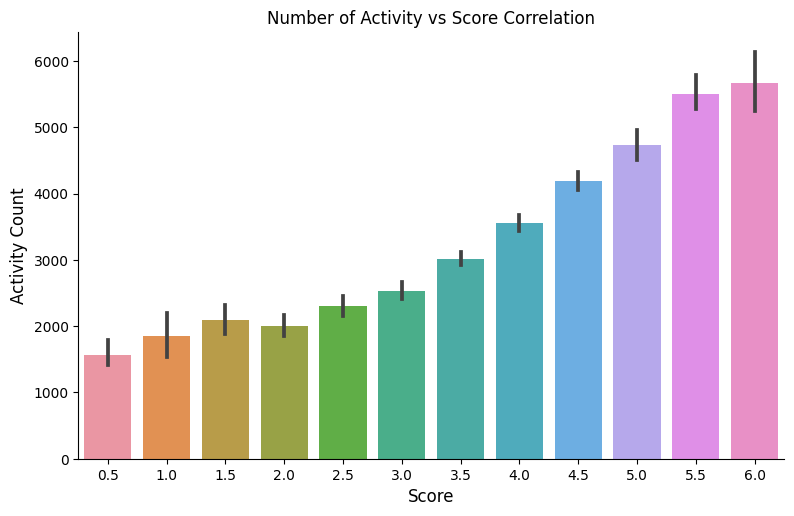

In [11]:
stats = train_logs.groupby("id")["activity"].count().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="activity", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Activity Count', fontsize=12)
plt.title("Number of Activity vs Score Correlation")
plt.show()

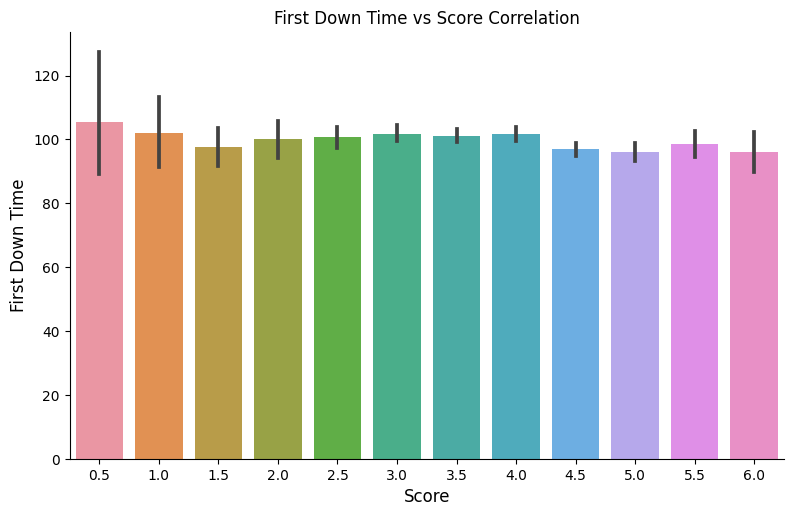

In [12]:
stats = train_logs.groupby("id")["action_time"].mean().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="action_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('First Down Time', fontsize=12)
plt.title("First Down Time vs Score Correlation")
plt.show()

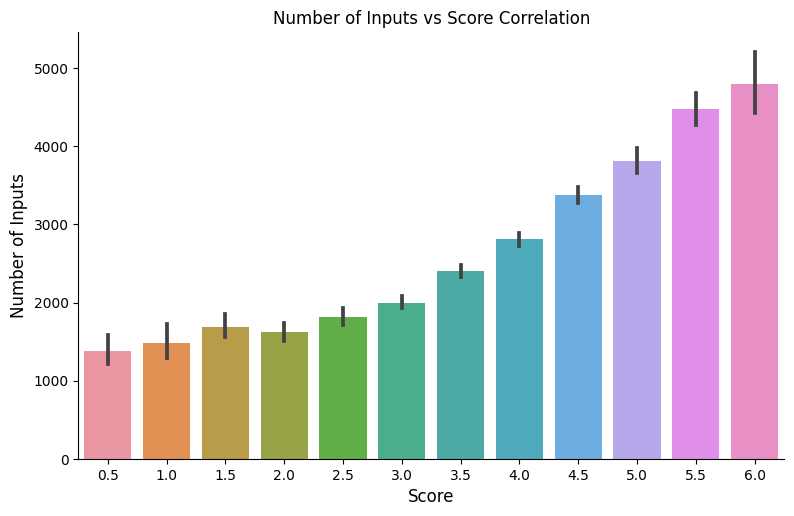

In [13]:
stats = train_logs.groupby("id")["activity"].value_counts().reset_index()
stats = stats[stats["activity"] == "Input"].reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Inputs', fontsize=12)
plt.title("Number of Inputs vs Score Correlation")
plt.show()

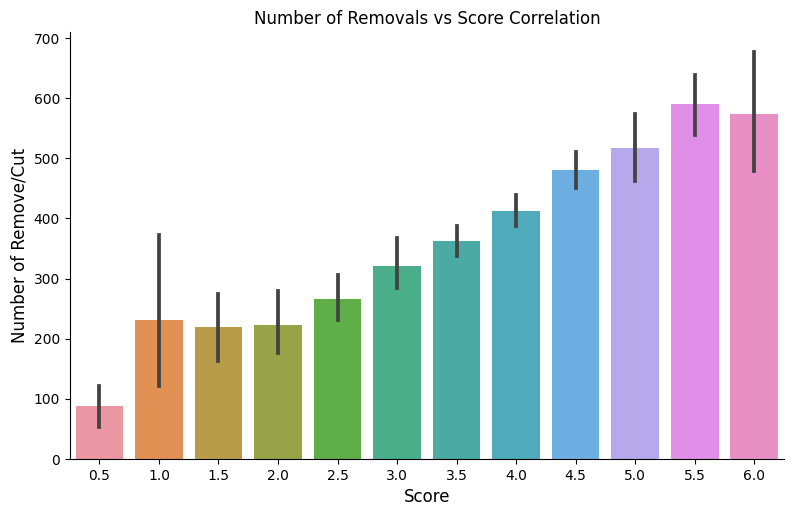

In [14]:
stats = train_logs.groupby("id")["activity"].value_counts().reset_index()
stats = stats[stats["activity"] == "Remove/Cut"].reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of Remove/Cut', fontsize=12)
plt.title("Number of Removals vs Score Correlation")
plt.show()

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6. ]
[  5  35  69  92 201 336 486 501 402 179 128  37]
[0.99797653 0.98583569 0.97207608 0.96276811 0.91865641 0.86402266
 0.80331849 0.79724808 0.83731283 0.92755969 0.94819911 0.98502631]


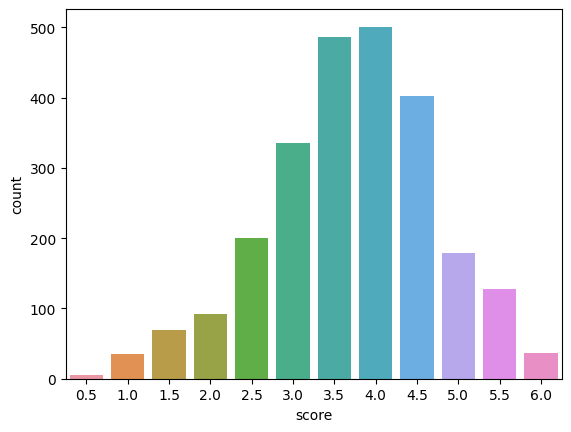

In [15]:
stats_label, stats_count = np.unique(train_scores.score, return_counts=True)
print(stats_label)
print(stats_count)
print(1 - (stats_count / 2471))
catplot = sns.barplot(x=train_scores.score.value_counts().index, y=train_scores.score.value_counts())
# plt.xlabel('Score', fontsize=12)
# plt.ylabel('First Down Time', fontsize=12)
# plt.title("First Down Time vs Score Correlation")
plt.show()

## Data preprocessing

##### Removing Outliers

In [16]:
PUNCUATION = ['!', '"', "'", '(', ')', ',', '.', ':', ';','?', '¡', '¿', '\\']
MAX_EVENT_START_TIME = 1_800_000 # miliseconds in 30 minutes.
NUMBER_OF_INTERVALS = 1_800 # = 1_800_000 msec / 250 milisecond intervals

NUM_FEATURES = 10
NUM_FEATURES_2 = 6
FINAL_LAYER_COUNT = 12

MAX_ACTION_TIME = 250
WORD_MAX = 800 # This is to divide all the word counts so that word count is still roughly 0-1 but keeps word count differentiable between papers.
EVENT_MAX = 6000 # Keeps Max number of event relavent but between 0-1 ish.
FIRST_DOWN_TIME_DIVISOR = 60_000
ACTIVITY_COUNT_DIVISOR = 6000
INSERT_COUNT_DIVISOR = 6000
REMOVAL_COUNT_DIVISOR = 700


def ScoreOneHot(score: float) -> np.array:
    result = np.zeros(12)
    result[int(score / 0.5) - 1] = 1
    return result
    

def TrainingPrep(df: pd.DataFrame):

    indexs_to_drop = df[df["down_time"] > df.down_time.quantile(0.999)].index
    df.drop(indexs_to_drop, inplace=True)
    indexs_to_drop = df[df["up_time"] > df.down_time.quantile(0.999)].index
    df.drop(indexs_to_drop, inplace=True)

    return df

def DfToX(df: pd.DataFrame, score: float = None) -> np.array:
    indexs_to_drop = df[df["action_time"] > MAX_ACTION_TIME].index
    df = df.drop(indexs_to_drop, axis=0)

    NumUniqueIds = len(np.unique(df["id"]))
    x_train_1 = np.zeros((NumUniqueIds, NUM_FEATURES, int(NUMBER_OF_INTERVALS)))
    x_train_2 = np.zeros((NumUniqueIds, NUM_FEATURES_2))
    #y_train = np.zeros((NumUniqueIds, FINAL_LAYER_COUNT))
    y_train = np.zeros(NumUniqueIds)
    
    groups = df.groupby("id")

    for index, id in enumerate(np.unique(df["id"])):
        if score is not None:
            #y_train[index] = ScoreOneHot(score)
            y_train[index] = np.float32(score)


        essayGroup = groups.get_group(id)
        max = essayGroup["down_time"].quantile(0.99)
        min = essayGroup["down_time"].quantile(0.01)
        range = max - min
        if range == 0:
            range = 1
        if range is None:
            range = 1

        MAX_CURSOR_POSITION = essayGroup["cursor_position"].max()

        if MAX_CURSOR_POSITION is None:
            print("MAX_CURSOR_POSITION is None")

        # Get X Train 2 (Non-convolution)
        ValueCounts = essayGroup.activity.value_counts().reset_index()
        x_train_2[index][0] = essayGroup.word_count.max() / WORD_MAX
        x_train_2[index][1] = essayGroup.event_id.max() / EVENT_MAX
        x_train_2[index][2] = essayGroup.down_time.min() / FIRST_DOWN_TIME_DIVISOR
        x_train_2[index][3] = essayGroup.activity.count() / ACTIVITY_COUNT_DIVISOR
        x_train_2[index][4] = ValueCounts[ValueCounts["activity"] == "Input"]["count"].max() / INSERT_COUNT_DIVISOR
        x_train_2[index][5] = ValueCounts[ValueCounts["activity"] == "Remove/Cut"]["count"].max() / REMOVAL_COUNT_DIVISOR

        if np.isnan(x_train_2[index][4]):
            x_train_2[index][4] = 0

        if np.isnan(x_train_2[index][5]):
            x_train_2[index][5] = 0

        # Build X Train 1 (convolution)
        for row in essayGroup.itertuples():

            if (row.down_time < min*0.9) or (row.down_time > max*1.1):
                continue

            start_index = floor(((row.down_time - min) / range) * NUMBER_OF_INTERVALS)

            if start_index >= NUMBER_OF_INTERVALS:
                start_index = NUMBER_OF_INTERVALS - 1

            if start_index < 0:
                start_index = 0
            
            match row.activity:
                case "Nonproduction":
                    x_train_1[index][2][start_index] += 1.0
                case "Input" | "Replace":
                    # Puncuation
                    if row.down_event in PUNCUATION:
                        x_train_1[index][6][start_index] += 1.0
                    elif row.down_event == "q":
                        x_train_1[index][7][start_index] += 1.0
                    else:
                        x_train_1[index][8][start_index] += 1.0

                case "Remove/Cut":
                    x_train_1[index][4][start_index] += 1.0
                case "Paste":
                    x_train_1[index][5][start_index] += 1.0
                case _:
                    if "Move From" in row.activity:
                        x_train_1[index][3][start_index] += 1.0
            
            if x_train_1[index][0][start_index] < (row.word_count / WORD_MAX):
                x_train_1[index][0][start_index] = (row.word_count / WORD_MAX)
            
            if x_train_1[index][1][start_index] < (row.cursor_position / MAX_CURSOR_POSITION):
                x_train_1[index][1][start_index] = (row.cursor_position / MAX_CURSOR_POSITION)
            
            if x_train_1[index][9][start_index] < (row.event_id / EVENT_MAX):
                x_train_1[index][9][start_index] = (row.event_id / EVENT_MAX)
        
        currentWordCount = 0
        for i, wordCount in enumerate(np.nditer(x_train_1[index][0])):
            if wordCount == 0:
                x_train_1[index][0] = currentWordCount
            elif currentWordCount != wordCount:
                currentWordCount = wordCount

        currentCursorPosition = 0
        for i, cursor in enumerate(np.nditer(x_train_1[index][1])):
            if cursor == 0:
                x_train_1[index][1] = currentCursorPosition
            elif cursor != currentCursorPosition:
                currentCursorPosition = cursor

        currentEventCount = 0
        for i, event in enumerate(np.nditer(x_train_1[index][1])):
            if event == 0:
                x_train_1[index][9] = currentEventCount
            elif event != currentEventCount:
                currentEventCount = event
                
    x_train_1 = np.transpose(x_train_1, axes=(0, 2, 1))
    return x_train_1, x_train_2, y_train

def GenerateNewExample(x_train: np.array):
    example_index = np.random.choice(len(x_train), 1)[0]
    Noise = (0.005 * np.random.sample(x_train[0].shape)) - 0.0025
    result = x_train[example_index] *  (1 + Noise)
    return result

In [17]:
NUM_EXAMPLES_UPPER_LIMIT = 400
NUM_EXAMPLES_LOWER_LIMIT = 30
TrainingPrep(train_logs)

x_train = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
x_train_2 = np.zeros((0, NUM_FEATURES_2))
#y_train = np.zeros((0, FINAL_LAYER_COUNT))
y_train = np.zeros(0)

x_valid = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
x_valid_2 = np.zeros((0, NUM_FEATURES_2))
#y_valid = np.zeros((0, FINAL_LAYER_COUNT))
y_valid = np.zeros(0)

x_test = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
x_test_2 = np.zeros((0, NUM_FEATURES_2))
#y_test = np.zeros((0, FINAL_LAYER_COUNT))
y_test = np.zeros(0)

for x in range(1, 13):
    ids = train_scores[train_scores["score"] == (x/2)]
    temp_train_x_1, temp_train_x_2, temp_train_y = DfToX(train_logs[train_logs["id"].isin(ids.id)], x/2)

    if len(temp_train_x_1) > NUM_EXAMPLES_UPPER_LIMIT:
        indicies_to_remove = np.random.choice(len(temp_train_x_1), len(temp_train_x_1) - NUM_EXAMPLES_UPPER_LIMIT, replace=False)
        temp_train_x_1 = np.delete(temp_train_x_1, indicies_to_remove, 0)
        temp_train_x_2 = np.delete(temp_train_x_2, indicies_to_remove, 0)
        temp_train_y = temp_train_y[:NUM_EXAMPLES_UPPER_LIMIT]
    
    if len(temp_train_x_1) < NUM_EXAMPLES_LOWER_LIMIT:
        while len(temp_train_x_1) < NUM_EXAMPLES_LOWER_LIMIT:
            randomExample1 = GenerateNewExample(x_train=temp_train_x_1)
            randomExample2 = GenerateNewExample(x_train=temp_train_x_2)
            temp_train_x_1 = np.concatenate((temp_train_x_1, [randomExample1]))
            temp_train_x_2 = np.concatenate((temp_train_x_2, [randomExample2]))
            temp_train_y = np.concatenate((temp_train_y, [temp_train_y[0]]))
    elif len(temp_train_x_1) < NUM_EXAMPLES_LOWER_LIMIT * 2:
        while len(temp_train_x_1) < NUM_EXAMPLES_LOWER_LIMIT * 2:
            randomExample1 = GenerateNewExample(x_train=temp_train_x_1)
            randomExample2 = GenerateNewExample(x_train=temp_train_x_2)
            temp_train_x_1 = np.concatenate((temp_train_x_1, [randomExample1]))
            temp_train_x_2 = np.concatenate((temp_train_x_2, [randomExample2]))
            temp_train_y = np.concatenate((temp_train_y, [temp_train_y[0]]))
    elif len(temp_train_x_1) < NUM_EXAMPLES_LOWER_LIMIT * 3:
        while len(temp_train_x_1) < NUM_EXAMPLES_LOWER_LIMIT * 2:
            randomExample1 = GenerateNewExample(x_train=temp_train_x_1)
            randomExample2 = GenerateNewExample(x_train=temp_train_x_2)
            temp_train_x_1 = np.concatenate((temp_train_x_1, [randomExample1]))
            temp_train_x_2 = np.concatenate((temp_train_x_2, [randomExample2]))
            temp_train_y = np.concatenate((temp_train_y, [temp_train_y[0]]))
    elif len(temp_train_x_1) < NUM_EXAMPLES_LOWER_LIMIT * 4:
        while len(temp_train_x_1) < NUM_EXAMPLES_LOWER_LIMIT * 2:
            randomExample1 = GenerateNewExample(x_train=temp_train_x_1)
            randomExample2 = GenerateNewExample(x_train=temp_train_x_2)
            temp_train_x_1 = np.concatenate((temp_train_x_1, [randomExample1]))
            temp_train_x_2 = np.concatenate((temp_train_x_2, [randomExample2]))
            temp_train_y = np.concatenate((temp_train_y, [temp_train_y[0]]))

    first_cutoff = floor(0.2 * len(temp_train_x_1))
    second_cutoff = first_cutoff * 2
    x_test = np.append(x_test, temp_train_x_1[:first_cutoff], axis=0)
    x_valid = np.append(x_valid, temp_train_x_1[first_cutoff:second_cutoff], axis=0)
    x_train = np.append(x_train, temp_train_x_1[second_cutoff:], axis=0)

    x_test_2 = np.append(x_test_2, temp_train_x_2[:first_cutoff], axis=0)
    x_valid_2 = np.append(x_valid_2, temp_train_x_2[first_cutoff:second_cutoff], axis=0)
    x_train_2 = np.append(x_train_2, temp_train_x_2[second_cutoff:], axis=0)

    y_test = np.append(y_test, temp_train_y[:first_cutoff], axis=0)
    y_valid = np.append(y_valid, temp_train_y[first_cutoff:second_cutoff], axis=0)
    y_train = np.append(y_train, temp_train_y[second_cutoff:], axis=0)

In [18]:
print(f"Shape of X Train: {x_train.shape}")
print(f"Shape of X Train 2: {x_train_2.shape}")
print(f"Shape of Y Train: {y_train.shape}\n")
print(f"Shape of X Valid: {x_valid.shape}")
print(f"Shape of X Valid 2: {x_valid_2.shape}")
print(f"Shape of Y Valid: {y_valid.shape}\n")
print(f"Shape of X Test: {x_test.shape}")
print(f"Shape of X Test 2: {x_test_2.shape}")
print(f"Shape of Y Test: {y_test.shape}\n")

Shape of X Train: (1419, 1800, 10)
Shape of X Train 2: (1419, 6)
Shape of Y Train: (1419,)

Shape of X Valid: (468, 1800, 10)
Shape of X Valid 2: (468, 6)
Shape of Y Valid: (468,)

Shape of X Test: (468, 1800, 10)
Shape of X Test 2: (468, 6)
Shape of Y Test: (468,)



In [19]:
for x in x_train_2:
    if np.any(np.isnan(x)):
        print(x)

In [20]:
input_shape_1 = (len(x_train), len(x_train[0]), len(x_train[0][0]))
input_shape_2 = (len(x_train_2), len(x_train_2[0]))
print(input_shape_1)
print(input_shape_2)

input_1 = tf.keras.Input(shape=input_shape_1[1:], dtype=np.float64)
input_2 = tf.keras.Input(shape=input_shape_2[1:], dtype=np.float64)

layers_1 = tf.keras.layers.Normalization()(input_1)
layers_1 = tf.keras.layers.Conv1D(filters=128, 
                                  kernel_size = (16,), 
                                  strides=2, 
                                  padding="SAME", 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                )(layers_1)
layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

layers_1 = tf.keras.layers.Conv1D(filters=12, 
                                  kernel_size = (8,), 
                                  strides=1, 
                                  padding="SAME", 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                )(layers_1)
layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

layers_1 = tf.keras.layers.Conv1D(filters=12, 
                                  kernel_size = (4,), 
                                  strides=1, 
                                  padding="SAME", 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                )(layers_1)
layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

layers_1 = tf.keras.layers.Flatten()(layers_1)
layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
layers_1 = tf.keras.layers.Dense(units=256, activation='relu')(layers_1)
layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
layers_1 = tf.keras.layers.Dense(units=24, activation='relu')(layers_1)
layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
layers_1 = tf.keras.layers.Dense(units=24, activation='relu')(layers_1)
model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

layers_2 = tf.keras.layers.Normalization()(input_2)
layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
layers_2 = tf.keras.layers.Dense(units=16, activation='relu')(layers_2)
layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
layers_2 = tf.keras.layers.Dense(units=4, activation='relu')(layers_2)
layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
layers_2 = tf.keras.layers.Dense(units=4, activation='relu')(layers_2)
model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

layers_3 = tf.keras.layers.Dense(units=1024, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
layers_3 = tf.keras.layers.Dense(units=4096, activation='relu')(layers_3)
layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
layers_3 = tf.keras.layers.Dense(units=4096, activation='relu')(layers_3)
layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
layers_3 = tf.keras.layers.Dense(units=1024, activation='relu')(layers_3)
layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(layers_3)
layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)
layers_3 = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.relu)(layers_3)

model = tf.keras.models.Model(inputs=[model_1.input, model_2.input], outputs=layers_3)
model.summary()

(1419, 1800, 10)
(1419, 6)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1800, 10)]           0         []                            
                                                                                                  
 normalization (Normalizati  (None, 1800, 10)             21        ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 conv1d (Conv1D)             (None, 900, 128)             20608     ['normalization[0][0]']       
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 450, 128)             0      

In [21]:
unique_scores, unique_scores_count = np.unique(train_scores.score, return_counts=True)
loss_weights = [x for x in ( 1.25 - ((1.25 * stats_count) / len(y_train)))]
#loss_weights = [1 for x in range(12)]
print(len(loss_weights))
print(loss_weights)

metrics = [
          tf.keras.metrics.RootMeanSquaredError(), 
        ]
model.compile(optimizer='adam', 
              loss="mse", 
              metrics=metrics,
            )

12
[1.2455954897815362, 1.219168428470754, 1.1892177589852009, 1.1689570119802677, 1.072938689217759, 0.9540169133192389, 0.8218816067653276, 0.8086680761099365, 0.895877378435518, 1.0923185341789994, 1.137244538407329, 1.2174066243833686]


In [22]:
# TODO: Make 4 models. A beginning model to get the low-med-high range value.
#   --: Then the last three will be built based on the low-med-high criteria. For example, if a essay is determinded to be "low"
#   --: by the first model then it will be tossed through the low-model and that will be the final result.
epochs = 60
history = model.fit(x=[x_train, x_train_2], y=y_train, validation_data=([x_valid, x_valid_2], y_valid), epochs=epochs)

Epoch 1/60
45/45 [==============================] - 5s 100ms/step - loss: 8.8583 - root_mean_squared_error: 2.8916 - val_loss: 1.6044 - val_root_mean_squared_error: 1.0593
Epoch 2/60
45/45 [==============================] - 5s 113ms/step - loss: 3.8428 - root_mean_squared_error: 1.8352 - val_loss: 2.1810 - val_root_mean_squared_error: 1.3091
Epoch 3/60
45/45 [==============================] - 4s 96ms/step - loss: 3.1994 - root_mean_squared_error: 1.6549 - val_loss: 1.7056 - val_root_mean_squared_error: 1.1187
Epoch 4/60
45/45 [==============================] - 4s 96ms/step - loss: 3.0959 - root_mean_squared_error: 1.6270 - val_loss: 1.6196 - val_root_mean_squared_error: 1.0849
Epoch 5/60
45/45 [==============================] - 4s 95ms/step - loss: 3.3871 - root_mean_squared_error: 1.7174 - val_loss: 1.3434 - val_root_mean_squared_error: 0.9546
Epoch 6/60
45/45 [==============================] - 4s 96ms/step - loss: 2.8527 - root_mean_squared_error: 1.5574 - val_loss: 1.8246 - val_root

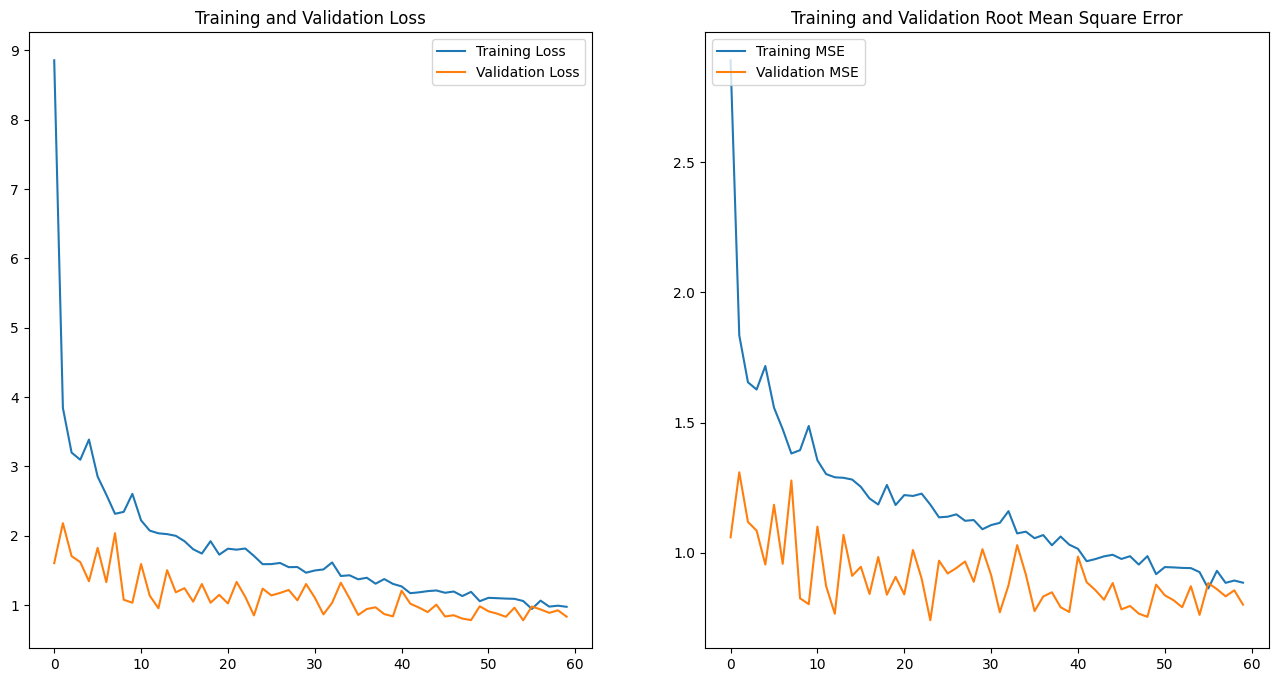

In [23]:
epochs_range = range(epochs)
rows = 1
cols = 2

loss = history.history['loss']
val_loss = history.history['val_loss']
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(rows, cols, 1)
#ax.set_ylim(0, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

MSE = history.history['root_mean_squared_error']
val_MSE = history.history['val_root_mean_squared_error']
ax = fig.add_subplot(rows, cols, 2)
#ax.set_ylim(0, 3)
plt.plot(epochs_range, MSE, label='Training MSE')
plt.plot(epochs_range, val_MSE, label='Validation MSE')
plt.legend(loc='upper left')
plt.title('Training and Validation Root Mean Square Error')
plt.show()


plt.show()



In [24]:
def OneColdCode(arr: list) -> float:
    score = 0.5
    max_score = 0.5
    highests = 0
    for i in arr:
        if i >= highests:
            highests = i
            max_score = score
        score += 0.5
    return max_score

def HalfRound(a: float) -> float:
    return round(a * 2) / 2.0

def SinglOutputProcessing(a: float) -> float:
    a = HalfRound(a)

    if a < 0.5:
        a = 0.5
    if a > 6.0:
        a = 6.0

    return a

15/15 [==============================] - 0s 23ms/step


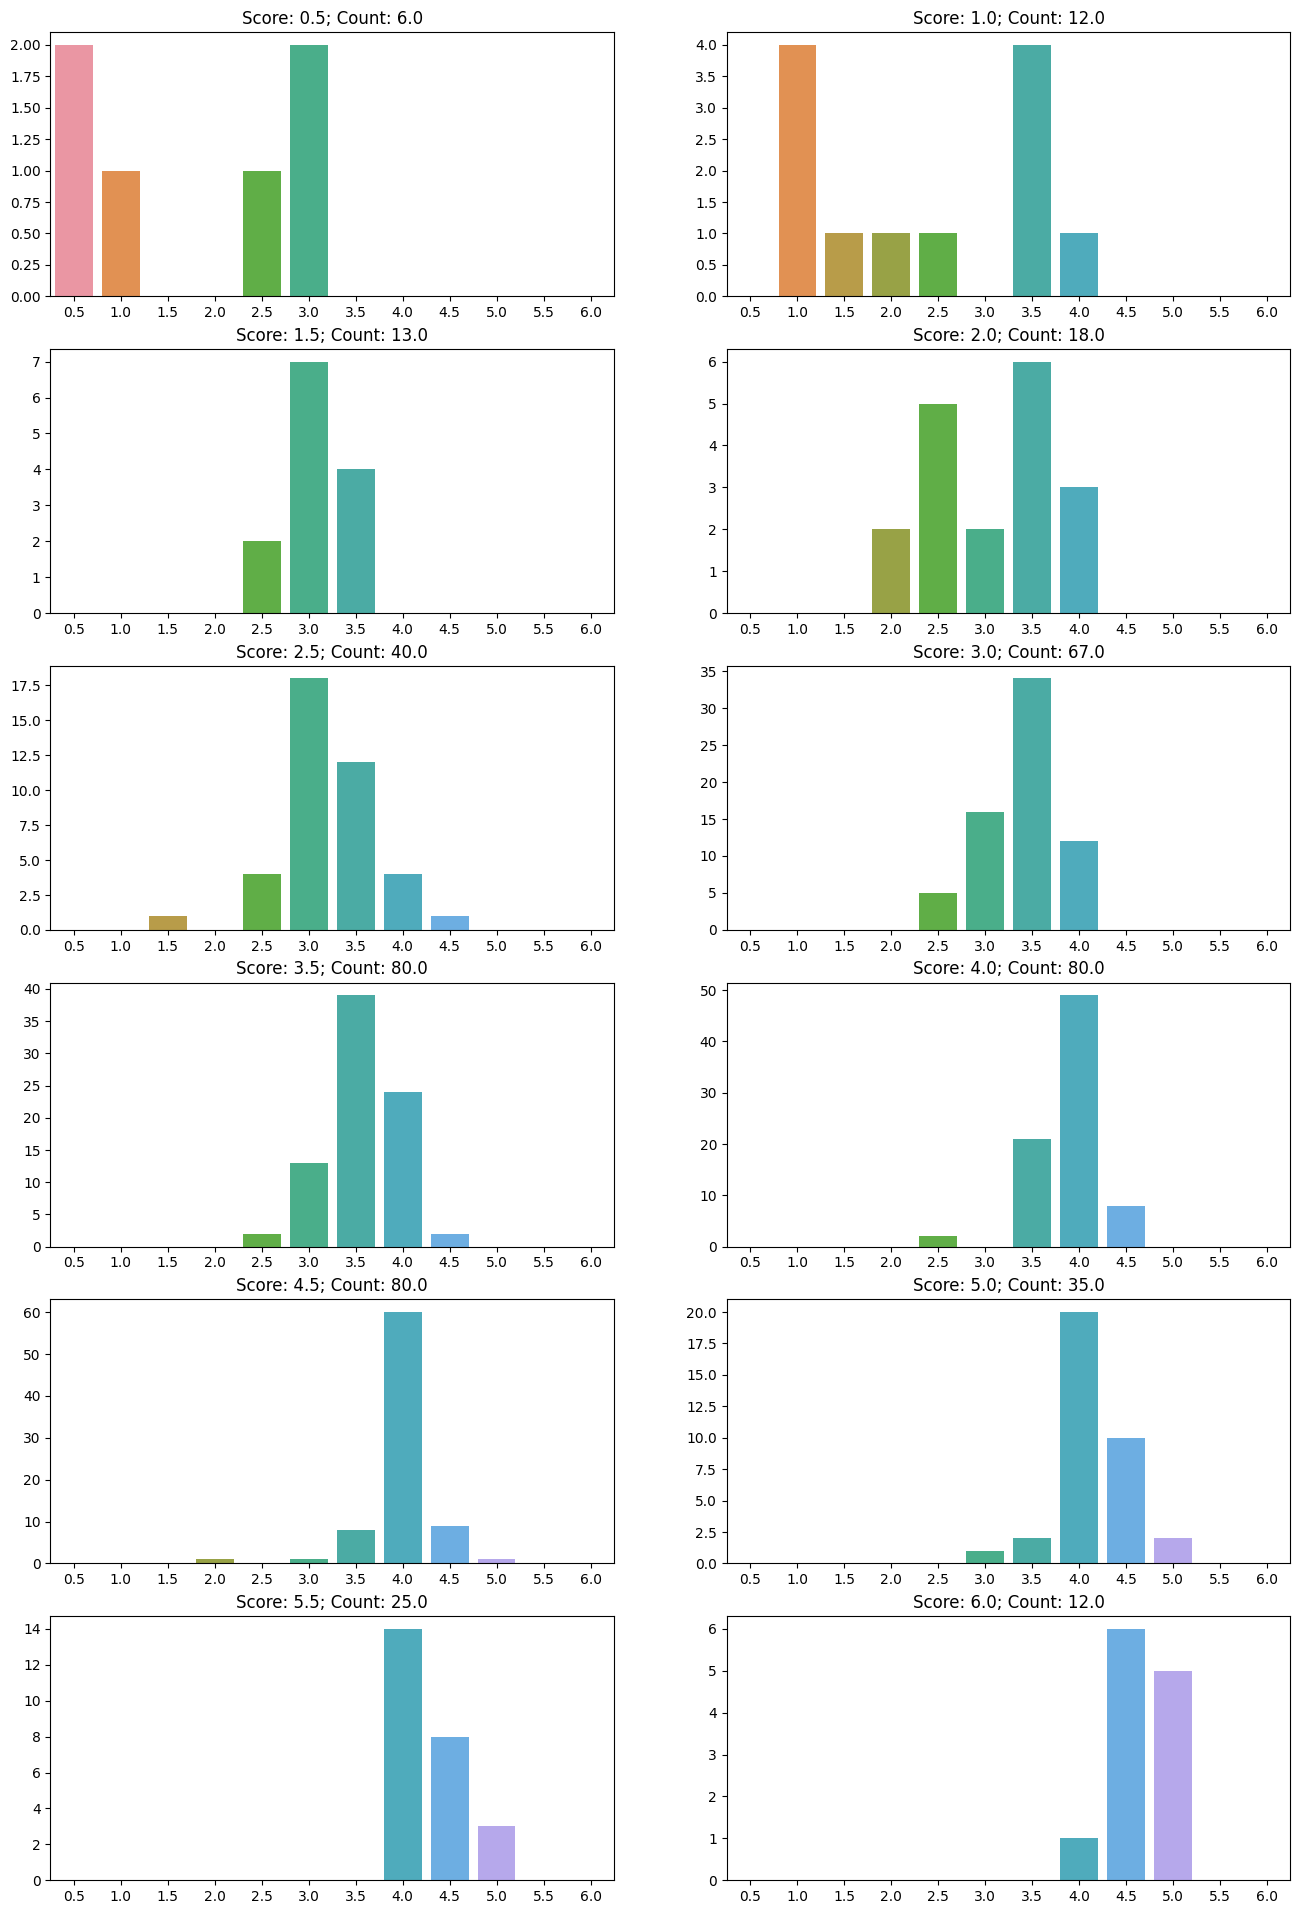

In [25]:
# TODO: Show graphs of the validation data and then have a seperate test one. This is to avoid
#       overfitting via make decisions based on the test set.

model.evaluate([x_test, x_test_2], y_test)
test_predictions = model.predict([x_test, x_test_2])
#test_predictions = [OneColdCode(x) for x in test_predictions]
#actual_values = np.array([OneColdCode(y) for y in y_test])

test_predictions = [SinglOutputProcessing(x[0]) for x in test_predictions]
actual_values = y_test

fig = plt.figure(figsize=(16, 24))
for i in range(1, 13, 1):
    count = np.zeros(12)

    for index, value in enumerate(actual_values):
        if value == i/2:
            count[int(test_predictions[index] * 2) - 1] += 1

    fig.add_subplot(6, 2, i)
    sns.barplot(x=[x/2 for x in range(1, 13)], y=count)
    plt.title(f'Score: {i/2}; Count: {count.sum()}')

plt.show()
test_predictions = pd.DataFrame({"y" : test_predictions, })

In [30]:
# 2c75e15a --> 4.0
# 2c7997a3 --> 3.5
# 2d299968 --> 5.0
#test_logs = pd.read_csv("./data/personaltest.csv")

predictions = []
for id in test_logs["id"].unique():
    pred_score = 3.5
    try:
        x_test, x_test_2, y_test = DfToX(test_logs[test_logs["id"] == id])
        pred = model.predict((x_test, x_test_2))
        pred_score = OneColdCode(pred[0])
        #pred_score = HalfRound(pred[0][0])
        #pred_score = pred[0][0]
    except ValueError as ex:
        pred_score = 3.5
        print(f"VALUE ERROR OCCURED. ERROR: {ex}")
    except Exception as ex:
        print(f"ERROR: {ex}")
        pred_score = 3.5
    finally:
        predictions.append((id, pred_score))

ids = [p[0] for p in predictions]
scores = [p[1] for p in predictions]

sample_submission["id"] = ids
sample_submission["score"] = scores
sample_submission[["id", "score"]].to_csv("submission.csv", index=False)

1/1 [==============================] - 0s 15ms/step


In [27]:
# try:
#     personal_test_logs = pd.read_csv("./data/personaltest.csv")
#     personal_ids = np.unique(personal_test_logs.id)
#     personal_test_scores = train_scores[train_scores["id"].isin(personal_ids)]
#     personal_test_logs = TrainingPrep(personal_test_logs)
#     personal_x_test, personal_x_test_2, personal_y_test = DfToX(personal_test_logs, personal_test_scores)

#     model.evaluate((personal_x_test, personal_x_test_2), personal_y_test)

#     personal_predictions = model.predict(personal_x_test)
#     for p in personal_predictions:
#         print(p)

#     personal_predictions = [OneColdCode(x) for x in personal_predictions]
#     personal_predictions = pd.DataFrame({"y" : personal_predictions, "x" : np.array([OneColdCode(y) for y in personal_y_test])})

#     sns.relplot(
#         data=personal_predictions, x="x", y="y"
#     )
# except Exception as ex:
#     print(f"Test box: {ex})")